## Spotify 2023 Data Analysis. 

### Preliminary Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display

print('packages imported')

packages imported


In [2]:
df = pd.read_csv(r'C:\Users\cindy\Documents\Projects\spotify_2023.csv', encoding='latin-1')
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [3]:
df.shape

(953, 24)

In [4]:
# Getting the summary statistics (mean, min, max, etc).
df.describe()

,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,in_apple_playlists,in_apple_charts,in_deezer_charts,bpm,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
count,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000,953.00000,953.000000,953.000000,953.000000,953.000000,953.000000,953.000000
mean,1.556139,2018.238195,6.033578,13.930745,5200.124869,12.009444,67.812172,51.908709,2.666317,122.540399,66.96957,51.431270,64.279119,27.057712,1.581322,18.213012,10.131165
std,0.893044,11.116218,3.566435,9.201949,7897.608990,19.575992,86.441493,50.630241,6.035599,28.057802,14.63061,23.480632,16.550526,25.996077,8.409800,13.711223,9.912888
min,1.000000,1930.000000,1.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,65.000000,23.00000,4.000000,9.000000,0.000000,0.000000,3.000000,2.000000
25%,1.000000,2020.000000,3.000000,6.000000,875.000000,0.000000,13.000000,7.000000,0.000000,100.000000,57.00000,32.000000,53.000000,6.000000,0.000000,10.000000,4.000000
50%,1.000000,2022.000000,6.000000,13.000000,2224.000000,3.000000,34.000000,38.000000,0.000000,121.000000,69.00000,51.000000,66.000000,18.000000,0.000000,12.000000,6.000000
75%,2.000000,2022.000000,9.000000,22.000000,5542.000000,16.000000,88.000000,87.000000,2.000000,140.000000,78.00000,70.000000,77.000000,43.000000,0.000000,24.000000,11.000000
max,8.000000,2023.000000,12.000000,31.000000,52898.000000,147.000000,672.000000,275.000000,58.000000,206.000000,96.00000,97.000000,97.000000,97.000000,91.000000,97.000000,64.000000


In [5]:
# check for null values, if there are null values, replace with 0
df.isnull().sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

In [6]:
# Replace the null values by 0
df['in_shazam_charts'].fillna(0, inplace=True)
df['key'].fillna(0, inplace=True)

df.isnull().sum()

track_name              0
artist(s)_name          0
artist_count            0
released_year           0
released_month          0
released_day            0
in_spotify_playlists    0
in_spotify_charts       0
streams                 0
in_apple_playlists      0
in_apple_charts         0
in_deezer_playlists     0
in_deezer_charts        0
in_shazam_charts        0
bpm                     0
key                     0
mode                    0
danceability_%          0
valence_%               0
energy_%                0
acousticness_%          0
instrumentalness_%      0
liveness_%              0
speechiness_%           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      953 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   953 non-null    ob

### Top 10 Most Streamed Tracks

In [8]:
# df['streams'] column is a object and needs to be changed to numerical. Find the non-numeric row and drop it.
df['streams'] = pd.to_numeric(df['streams'], errors = 'coerce', downcast='integer')
non_num  = df[df['streams'].isna()]
# drop row and reset index
df.drop(574, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.shape

(952, 24)

In [9]:
print(df['streams'].dtype)

float64


In [10]:
# What are the top 10 most streamed songs of 2022?
#Order 'streams' in desc order 
top_10_songs = df.sort_values(by='streams', ascending=False).head(10)
top_10_songs.reset_index(drop=True, inplace=True)

top_10_songs.head(10)

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Blinding Lights,The Weeknd,1,2019,11,29,43899,69,3.703895e+09,672,...,171,C#,Major,50,38,80,0,0,9,7
1,Shape of You,Ed Sheeran,1,2017,1,6,32181,10,3.562544e+09,33,...,96,C#,Minor,83,93,65,58,0,9,8
2,Someone You Loved,Lewis Capaldi,1,2018,11,8,17836,53,2.887242e+09,440,...,110,C#,Major,50,45,41,75,0,11,3
3,Dance Monkey,Tones and I,1,2019,5,10,24529,0,2.864792e+09,533,...,98,F#,Minor,82,54,59,69,0,18,10
4,Sunflower - Spider-Man: Into the Spider-Verse,"Post Malone, Swae Lee",2,2018,10,9,24094,78,2.808097e+09,372,...,90,D,Major,76,91,50,54,0,7,5
5,One Dance,"Drake, WizKid, Kyla",3,2016,4,4,43257,24,2.713922e+09,433,...,104,C#,Major,77,36,63,1,0,36,5
6,STAY (with Justin Bieber),"Justin Bieber, The Kid Laroi",2,2021,7,9,17050,36,2.665344e+09,492,...,170,C#,Major,59,48,76,4,0,10,5
7,Believer,Imagine Dragons,1,2017,1,31,18986,23,2.594040e+09,250,...,125,A#,Minor,77,74,78,4,0,23,11
8,Closer,"The Chainsmokers, Halsey",2,2016,5,31,28032,0,2.591224e+09,315,...,95,G#,Major,75,64,52,41,0,11,3
9,Starboy,"The Weeknd, Daft Punk",2,2016,9,21,29536,79,2.565530e+09,281,...,186,G,Major,68,49,59,16,0,13,28


c:\Users\cindy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cindy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\cindy\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


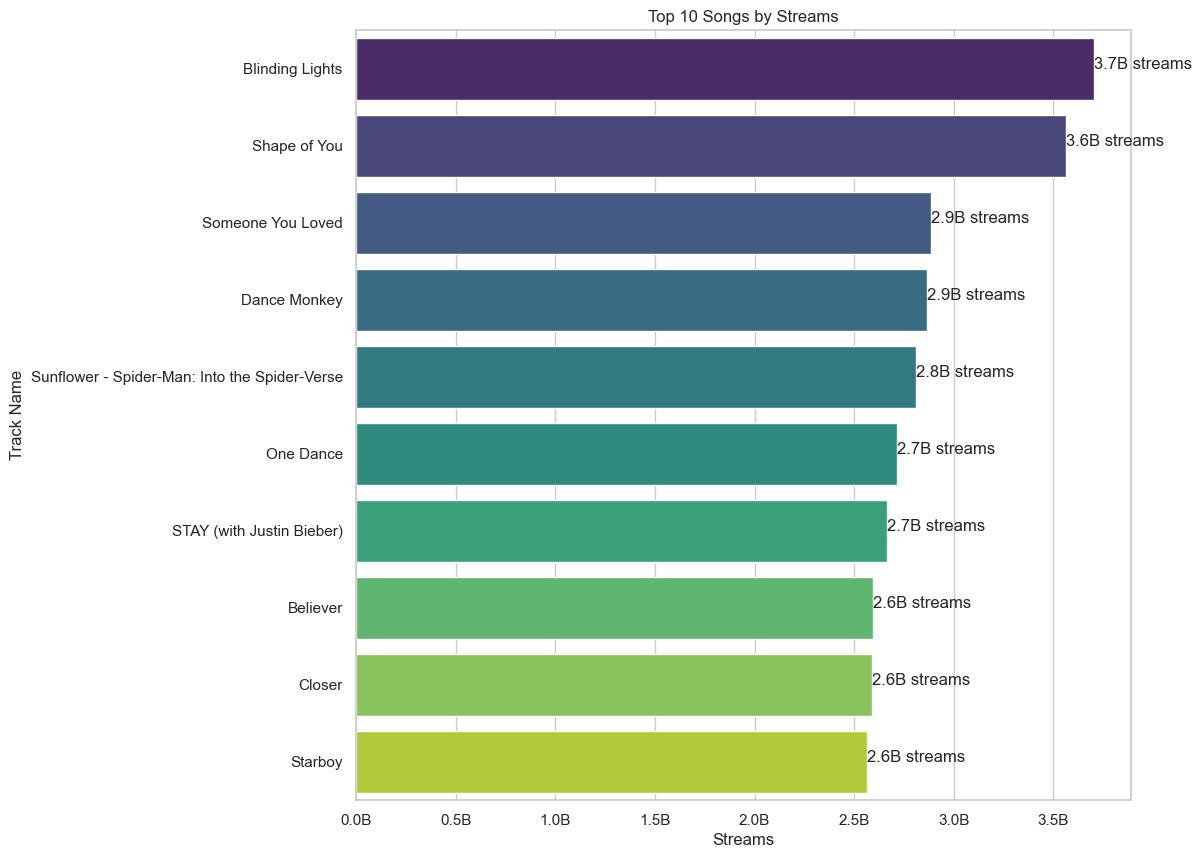

In [11]:
#create a bar chart to visualize top 10 songs
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='streams', y='track_name', data=top_10_songs, palette="viridis")

# Add labels and title
ax.set(xlabel="Streams", ylabel="Track Name")
plt.title("Top 10 Songs by Streams")

# Define a custom tick formatter function
def billions_formatter(x, pos):
    return f'{x / 1e9:.1f}B'

# Apply the custom formatter to the x-axis
plt.gca().xaxis.set_major_formatter(FuncFormatter(billions_formatter))

# Annotate the bars with stream counts
for index, row in top_10_songs.iterrows():
    plt.text(row['streams'], index, f"{row['streams'] / 1e9:.1f}B streams")


# Show the plot
plt.show()

### Top 10 Most Streamed Artist